In [1]:
import json
import os
import ast
import csv
import io
from io import StringIO, BytesIO, TextIOWrapper
import gzip
from datetime import datetime, date
from s3_utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import ast
from datetime import timedelta
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn.model_selection import cross_val_score, ShuffleSplit, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import warnings
import sys
import time
warnings.filterwarnings("ignore")

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-n4ioshec because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Define s3 bucket
bucket = 'fouryouandme-study-data'

#List s3 keys
# get_matching_s3_keys(bucket, prefix='bump/') #Remove prefix to view non-BUMP data
bucket = '4youandme-study-data' # for SinC project
bucket = 'fouryouandme-study-data' # for 4YouandMe, Bump, CamCog or Bodyport project

# prefix = {study_name} or {study_name}/{source}
# sources: app_activities, bodyport, camcog, garmin, oura, redcap, rescuetime
# note camcog not accessible to bodyport (and vice a versa)
get_matching_s3_keys(bucket, prefix='bump/oura')
key = 'bump/redcap/wave_4/study_ids.csv.gz'
df_studyID = pandas_from_csv_s3(bucket, key=key, compression='gzip')

# Some dataframes use 'record_id' instead of 'user_id'. 
# You'll need to match it up with df_studyID where'evidation_id' is 'user_id'
# NOTE: Very few examples of this. Birthing data is the important one

# Birthing Data
key = 'bump/redcap/wave_4/birthing_data_cohort_2_only.csv.gz'
df_birth = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_birth['date'] = pd.to_datetime(df_birth.birth_date).dt.date


df_birth = pd.merge(df_birth, df_studyID, on='record_id')
df_birth['user_id'] = df_birth.evidation_id

# There is a missing value in the birthing data. I'm removing it here
df_birth = df_birth.drop(index=50)

# Bodyport Wave 4
key = 'bump/bodyport/wave_4/bodyport.csv.gz'
df_bodyport = pandas_from_csv_s3(bucket, key=key, compression='gzip')
# OPTIONAL: Convert date format
df_bodyport['date'] = pd.to_datetime(df_bodyport.event_date).dt.date 

# Oura Wave 4
key = 'bump/oura/wave_4/oura_sleep.csv.gz'
df_sleep = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_sleep['date'] = pd.to_datetime(df_sleep.event_date).dt.date

key = 'bump/oura/wave_4/oura_activity.csv.gz'
df_activity = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_activity['date'] = pd.to_datetime(df_activity.event_date).dt.date

key = 'bump/oura/wave_4/oura_readiness.csv.gz'
df_readiness = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_readiness['date'] = pd.to_datetime(df_readiness.event_date).dt.date

# Surveys Wave 4
key = 'bump/app_activities/wave_4/surveys.csv.gz'
df_survey = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_survey['date'] = pd.to_datetime(df_survey.updated_at).dt.date

key = 'bump/app_activities/wave_4/quick_activities.csv.gz'
df_sam = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_sam['date'] = pd.to_datetime(df_sam.event_date).dt.date

dfs = [df_sleep, df_bodyport, df_birth, df_activity, df_readiness, df_survey, df_sam]

In [3]:
# get all column names in merged dfs
names = []
for df in dfs:
    [names.append(i) for i in df.columns.to_list()]

In [4]:
bodyport_features = [
    # 'heart_rate',
    # 'breath_average',
    # 'peripheral_fluid',
    # 'total_body_water_percent',
    # 'weight_kg'
]
oura_features = [
    # 'hr_lowest',
    'hr_average',
    'rmssd',
    # 'score_deep',
    # 'temperature_deviation',
    # 'temperature_trend_deviation',
    # 'temperature_delta',
    # 'duration',
    # 'rem',
    # 'efficiency',
    # 'score_alignment',
    # 'score_rem',
    # 'light',
    # 'onset_latency',
    # 'restless',
    'breath_average',
    # 'score_disturbances',
    'score',
    # 'score_efficiency',
    # 'score_latency',
    # 'score_total'
]
feature_names = bodyport_features + oura_features
date_list = [
    "d", "id_x", 
    "user_id_x", 
    "identity_id_x", 
    "created_at_x", 
    "updated_at_x", 
    "retrieved_at_x", 
    "subsource_x", 
    "event_date_x",
    "date", "id_y", 
    "user_id_y", 
    "identity_id_y", 
    "created_at_y", 
    "updated_at_y", 
    "retrieved_at_y", 
    "subsource_y", 
    "creation_date", 
    "event_date_y"
]

In [5]:
def get_user(user_id, start=None, end=None):
    user_sleep = df_sleep[df_sleep.user_id == user_id]#.dropna()
    user_bp = df_bodyport[df_bodyport.user_id == user_id]#.dropna()
    
    df2 = pd.merge(user_sleep, user_bp, on="date")

    if "creation_date" in df2.columns:
        for i in range(len(df2)):
            df2["creation_date"][i] = dt.datetime.strptime(df2["creation_date"][i], '%Y-%m-%d %H:%M:%S')
    df2.set_index(df2["date"], inplace=True)
    df2.sort_index(inplace=True)
    
    if start and end:
        mask = (df2['date'] > np.datetime64(start)) & (df2['date'] <= np.datetime64(end))
        # mask = pd.to_datetime(df2["date"]).between(start.astype(str)[0], end.astype(str)[0], inclusive=True)
        df2 = df2[mask]
    return df2

In [6]:
#merge all data features
close_users = []
close_users_id = []
start_close_days = 90
for user_id in tqdm(df_birth[['birth_scheduled', 'birth_date', 'user_id']].dropna().user_id.unique()):
    birth = df_birth.loc[df_birth.user_id == user_id]
    birthdate = birth.reset_index()['date'][0]
    schedule_birth = birth['birth_scheduled'].to_list()[0] #schedule_birth == 1: induced deliveries; schedule_birth == 2: non induced
    if len(birth) > 0 and pd.isnull(birthdate) == False and schedule_birth == 2:
        start = birthdate - pd.to_timedelta(start_close_days, unit='d') # pd.to_timedelta(100, unit='d')
        end = birthdate + pd.to_timedelta(5, unit='d')
        date_range = pd.date_range(start, end, freq='d')
        df = get_user(user_id, start, birthdate)
        dr = pd.DataFrame()
        dr["d"] = date_range.date
        dr.set_index(dr.d, inplace=True)
        df = dr.join(df)
        df = df[feature_names + date_list]
        if df.isna().sum().max() < round(start_close_days) / 2: # max null counts in each col is less than 5
            df.set_index(df.d - df.d.min(), inplace=True)
            df = df.resample("D").mean()
            df.set_index(df.index.days, inplace=True)
            # df = df.interpolate("linear", 0) #linear interpolation on data
            df = df.fillna(method='ffill')
            df = df.fillna(df.mean(0))
            close_users.append(df)
            close_users_id.append(user_id)
            

100%|██████████| 138/138 [00:03<00:00, 45.58it/s]


In [8]:
close_users_id

[42.0,
 47.0,
 54.0,
 67.0,
 95.0,
 118.0,
 135.0,
 137.0,
 159.0,
 185.0,
 234.0,
 289.0,
 290.0,
 404.0,
 407.0,
 1047.0,
 604.0,
 1032.0,
 983.0,
 966.0,
 969.0,
 1041.0,
 1038.0,
 1427.0,
 1695.0,
 1453.0,
 1717.0]

In [16]:
import pickle
from sklearn.preprocessing import MinMaxScaler
for i in range(len(close_users)):
    x = close_users[i][feature_names].to_numpy()
    scaler = MinMaxScaler()
    x_ = scaler.fit_transform(x)
    with open(f'/mnt/TiVaCPD/TiVaCPD/data/bump_scheduled/user_{i}.pkl','wb') as f:
        pickle.dump(x_, f)

In [15]:
from klcpd import KL_CPD
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

i = 0
ts = np.load(f'/mnt/TiVaCPD/TiVaCPD/data/bump_test/user_{i}.pkl', allow_pickle=True)
dim, seq_length = ts.shape[1], ts.shape[0]
# scaler = MinMaxScaler()
# ts_transform = scaler.fit_transform(ts)
# device = torch.device('cuda')


In [17]:
model = KL_CPD(dim)
model.fit(ts)
preds = model.predict(ts)
print(preds)

100%|██████████| 100/100 [04:12<00:00,  2.52s/it]
[5.0962324  5.8636637  5.5484776  5.1773596  4.7457848  4.42275
 3.901808   3.496478   3.3593805  3.2197852  2.9269893  2.8036108
 2.4169466  1.9205058  1.5773288  1.2374494  1.0302172  0.9272173
 0.77643126 0.65898335 0.5383236  0.4520045  0.4101978  0.3785391
 0.39672005 0.4654267  0.5188841  0.5077319  0.54514426 0.55955046
 0.54073966 0.4916379  0.5014649  0.44533765 0.37107578 0.35605788
 0.27758616 0.2686894  0.24543682 0.34146082 0.4410135  0.38595414
 0.37852424 0.31073534 0.3290397  0.47055945 0.49637187 0.5105038
 0.42560244 0.29351512 0.1939959  0.19004136 0.16710702 0.15699203
 0.15746407 0.13320993 0.1915155  0.18279226 0.26550597 0.3619215
 0.47208387 0.5636785  0.67368025 0.74942464 0.89940405 0.8015416
 0.7698285  0.7042759  0.6669231  0.5707953  0.46921188 0.44470018
 0.50169194 0.56462765 0.6646496  0.7512496  0.696609   0.671118
 0.65776515 0.51522434 0.32129222 0.20970172 0.16872601 0.2033847
 0.3095613  0.46159095 0

In [20]:
type(preds)

numpy.ndarray

In [28]:
scaler = MinMaxScaler()
preds_transform = scaler.fit_transform(np.array([preds]).T)

Text(0.5, 1.0, 'change point detection results - user 159')

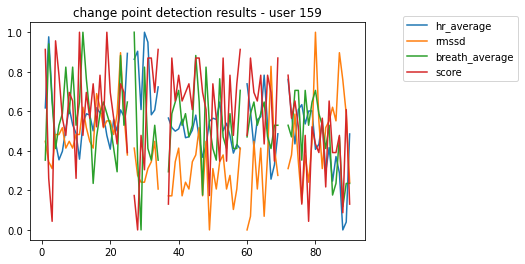

In [16]:
# plt.plot(preds_transform.T[0], c='purple', label='change point detection')
for i in range(x_.shape[1]):
    plt.plot(x_[:,i], label=feature_names[i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title(f'change point detection results - user {int(close_users_id[0])}')

In [38]:
ts[:,0]

array([0.42383418, 0.41913215, 0.43441815, 0.42209073, 0.38017751,
       0.35897436, 0.39250493, 0.51183432, 0.28451677, 1.        ,
       0.60157791, 0.53057199, 0.45019724, 0.47140039, 0.39349112,
       0.46696252, 0.39940828, 0.24901381, 0.43145957, 0.38412229,
       0.46696252, 0.42383418, 0.51824458, 0.5147929 , 0.40236686,
       0.46597633, 0.42357002, 0.47781065, 0.5300789 , 0.53303748,
       0.58136095, 0.52169625, 0.47287968, 0.62031558, 0.34418146,
       0.63017751, 0.59714004, 0.59516765, 0.43688363, 0.47830375,
       0.47287968, 0.78353057, 0.64250493, 0.56311637, 0.41074951,
       0.53846154, 0.55670611, 0.42383418, 0.59911243, 0.65828402,
       0.53648915, 0.47633136, 0.42383418, 0.58629191, 0.41420118,
       0.49013807, 0.73076923, 0.66715976, 0.63658777, 0.72583826,
       0.5438856 , 0.30670611, 0.38905325, 0.31656805, 0.30177515,
       0.35552268, 0.3382643 , 0.10552268, 0.2790927 , 0.35650888,
       0.27859961, 0.24852071, 0.34861933, 0.25887574, 0.33530

In [43]:
close_users_id

[159.0, 407.0, 983.0]